# Digital Image Processing<br> Problem 5<br> Felix Neutatz

##Image restoration

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from functools import partial

In [3]:
def plotGreyImage(imageToPlot, title):
    plt.imshow(imageToPlot, cmap='gray') #Greys_r
    plt.title(title)
    plt.axis('off')
    plt.show()

In [4]:
def processing(image):
    for x in range (image.shape[0]):
        for y in range (image.shape[1]):
            image[x,y] = image[x,y] * ((-1)**(x + y))
    return image

In [5]:
def H(u, v, a, b, T):
    pi_uavb = np.pi * (u * a + v * b)
    
    if (pi_uavb == 0):
        return 1
    
    h = ((T / pi_uavb) * np.sin(pi_uavb) * np.exp(-1j * pi_uavb))
    
    if (h == 0):
        return 0.000001
    else:
        return h

In [6]:
def blurring_filter(u, v, shape, T, a, b):
    
    u = u - (shape[0] / 2)
    v = v - (shape[1] / 2)
    
    return H(u, v, a, b, T)

In [7]:
def inverse_blurring_filter(u, v, shape, T, a, b):
    
    u = u - (shape[0] / 2)
    v = v - (shape[1] / 2)
    
    h = H(u, v, a, b, T)
    return (1.0 / h)

In [8]:
def wiener_filter(u, v, shape, T, a, b, K):
    u = u - (shape[0] / 2)
    v = v - (shape[1] / 2)
    
    h = H(u, v, a, b, T)
    return (1.0 / h) - (np.power(h,2) / (np.power(h,2) + K))

In [9]:
def filter_Function(ff, function):
    matrix = np.matrix(ff.copy(), dtype="complex128")
    for x in range(matrix.shape[0]):
        for y in range(matrix.shape[1]):
            matrix[x,y] = matrix[x,y] * function(x,y)
    
    return matrix

In [10]:
def filter_only(ff, function):
    matrix = np.matrix(ff.copy(), dtype="complex128")
    for x in range(matrix.shape[0]):
        for y in range(matrix.shape[1]):
            matrix[x,y] = function(x,y)
    
    return matrix

In [11]:
def filterFrequency(imageName, ffunction):
    img = mpimg.imread(imageName)
    preprocessed = processing(img)
    newImage = np.fft.fft2(preprocessed)
    
    filtered = filter_Function(ff = newImage, function = ffunction)
    result = np.fft.ifft2(filtered)
    
    postprocessed = processing(result.real)
    
    return postprocessed    

In [12]:
def test_filter(function, name, test_size = 500):
    test_image = np.ones((test_size,test_size)) * 255
    test_result = filter_Function(test_image, partial(function))
    plotGreyImage(np.abs(test_result), name)

    data = np.arange(0,test_size,1)
    test_plt = [0.0] * len(data)
    for i in range(len(data)):
        test_plt[i] = function(data[i])
    plt.plot(test_plt)
    plt.show

In [13]:
def zero_padding(img, pixels):
    padding = np.zeros((img.shape[0] + pixels*2, img.shape[1] + pixels*2))
    
    padding[pixels:(img.shape[0]+pixels),pixels:(img.shape[1]+pixels)] = img
    
    return padding

In [14]:
def crop_image(img, pixels):
    return(img[ pixels:(img.shape[0]-pixels),pixels:(img.shape[1]-pixels) ])

In [15]:
def butterworth_lowpass(u, v, shape, D0, n):
    d = np.sqrt((u - int(shape[0]/2)) ** 2 + (v - int(shape[1]/2)) ** 2)
    return (1 / (1 + (float(d) / D0)**(2 * n)))

In [16]:
def ideal_lowpass(u, v, shape, D0):
    d = np.sqrt((u - int(shape[0]/2)) ** 2 + (v - int(shape[1]/2)) ** 2)
    if float(d) > D0:
        return 0.0
    else:
        return 1.0

In [17]:
def gaussian_noise(mu, sigma, shape):
    gaussian_noise = np.random.normal(loc=mu, scale=sigma, size=shape)

    OldMin = np.min(gaussian_noise)
    OldMax = np.max(gaussian_noise)
    NewMin = 0
    NewMax = 255

    gaussian_noise_remapped = (((gaussian_noise - OldMin) * (NewMax - NewMin)) / (OldMax - OldMin)) + NewMin
    
    return gaussian_noise_remapped

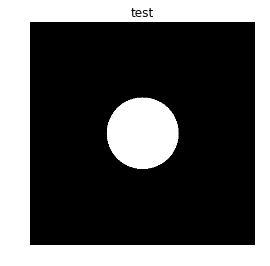

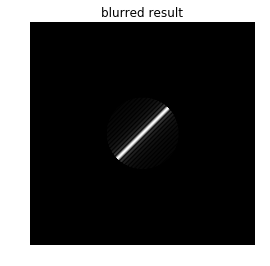

In [18]:
test_size = 500
test_image = np.ones((test_size,test_size)) * 255
test_result = filter_Function(test_image, partial(ideal_lowpass, shape = test_image.shape, D0 = 80))
plotGreyImage(np.abs(test_result), "test")

blur = partial(blurring_filter, shape = test_image.shape, T = 1, a = 0.1, b = 0.1)
filtered = filter_Function(test_result, blur)

plotGreyImage(np.abs(filtered), "blurred result")

In [19]:
def blurring(img, a, b, T):
    img2 = np.copy(img)
    for index, val in np.ndenumerate(img):
        x = index[0] - (img.shape[0]/2)
        y = index[1] - (img.shape[1]/2)
        img2[index] = val * H(a,b,T,x,y)
    return img2

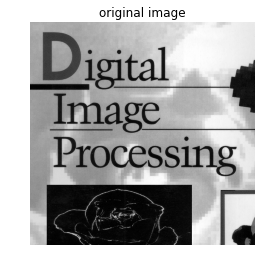

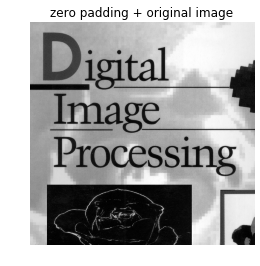

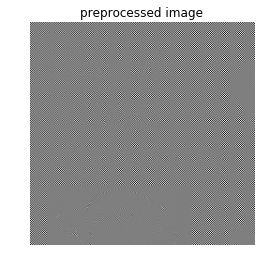

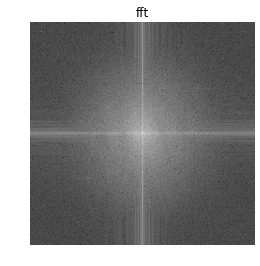

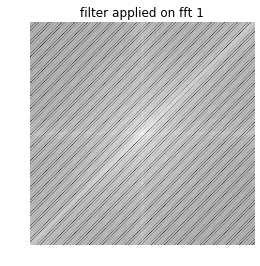

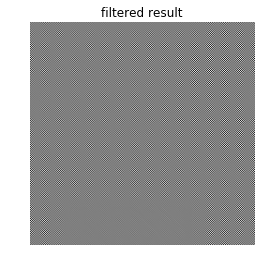

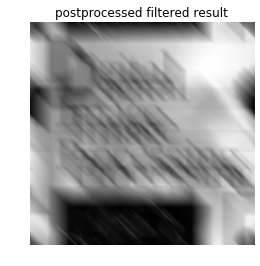

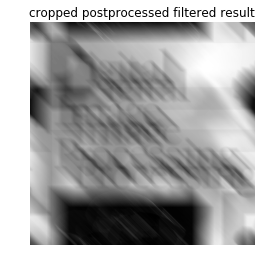

In [28]:
padding_size = 1

imageName = 'book_cover.jpg'
img = mpimg.imread(imageName)
plotGreyImage(img, "original image")

pad = zero_padding(img, padding_size)
plotGreyImage(pad, "zero padding + original image")

preprocessed = processing(pad)
plotGreyImage(preprocessed, "preprocessed image")

newImage = np.fft.fft2(preprocessed)
plotGreyImage(np.log(np.abs(newImage)), "fft")

blur = partial(blurring_filter, shape = newImage.shape,T = 1, a = 0.1, b = 0.1)
filtered = filter_Function(newImage, blur)
plotGreyImage(np.log(np.abs(filtered)), "filter applied on fft 1")

result = np.fft.ifft2(filtered)
plotGreyImage(result.real, "filtered result")

postprocessed = processing(result.real)

plotGreyImage(postprocessed, "postprocessed filtered result")

G = crop_image (postprocessed, padding_size)
plotGreyImage(G, "cropped postprocessed filtered result")

In [29]:
def apply_inverse(fft_image, inverse_filter, v = True):
    filteredt = filter_Function(fft_image, inverse_filter)
    
    result = np.fft.ifft2(filteredt)
    
    postprocessed = processing(result.real)

    cropped = crop_image (postprocessed, padding_size)
    
    if(v):
        plotGreyImage(np.log(np.abs(filteredt)), "filter applied on fft")
        plotGreyImage(result.real, "filtered result")
        plotGreyImage(postprocessed, "postprocessed filtered result")
        plotGreyImage(cropped, "cropped postprocessed filtered result")
    
    return cropped

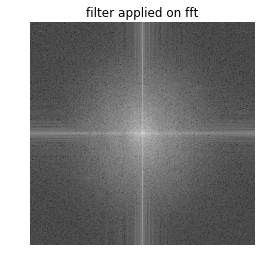

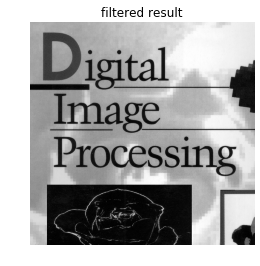

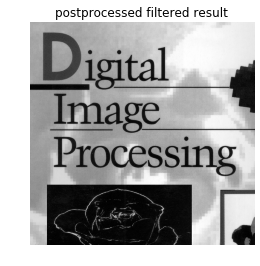

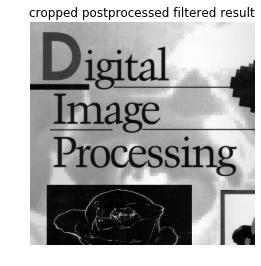

In [30]:
inverse_blur = partial(inverse_blurring_filter, shape = filtered.shape,T = 1, a = 0.1, b = 0.1)
apply_inverse(filtered, inverse_blur);

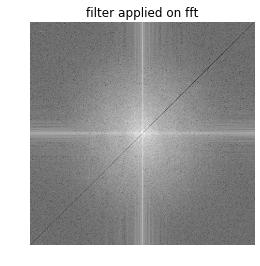

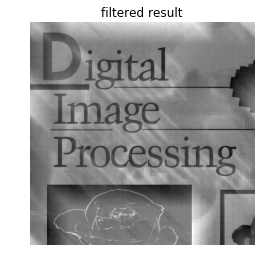

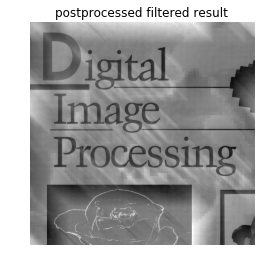

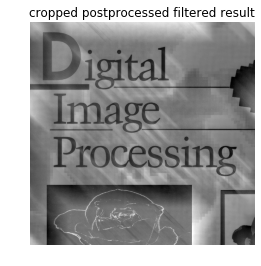

In [31]:
inverse_blur =  partial(wiener_filter, shape = filtered.shape,T = 1, a = 0.1, b = 0.1, K=0.006)
apply_inverse(filtered, inverse_blur);

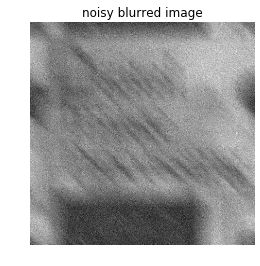

In [32]:
#add noise to blurred image
mean = 0
variance = 650

gaussian = gaussian_noise(0, np.sqrt(variance), G.shape)

noisy_blurred_img = G + gaussian
plotGreyImage(noisy_blurred_img, "noisy blurred image")

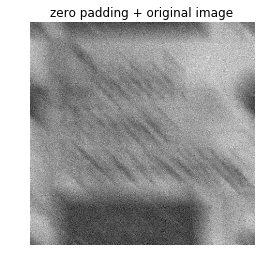

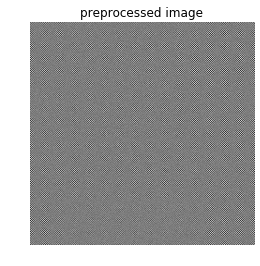

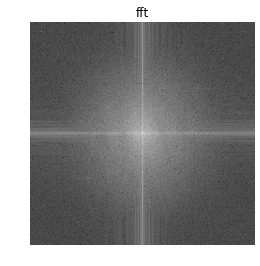

In [33]:
pad = zero_padding(noisy_blurred_img, padding_size)
plotGreyImage(pad, "zero padding + original image")

preprocessed = processing(pad)
plotGreyImage(preprocessed, "preprocessed image")

noisy_fft = np.fft.fft2(preprocessed)
plotGreyImage(np.log(np.abs(newImage)), "fft")

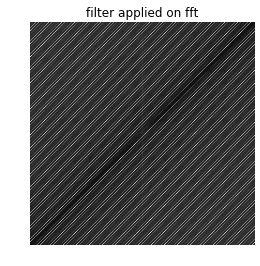

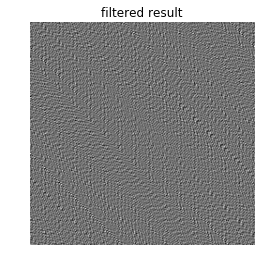

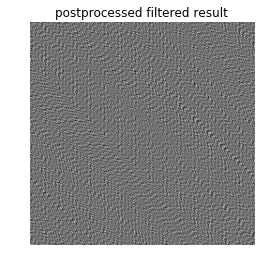

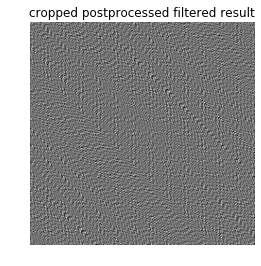

In [34]:
inverse_blur = partial(inverse_blurring_filter, shape = noisy_fft.shape,T = 1, a = 0.1, b = 0.1)
apply_inverse(noisy_fft, inverse_blur);

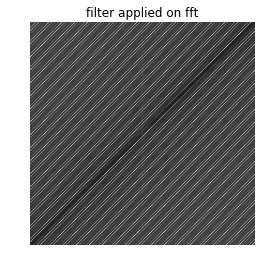

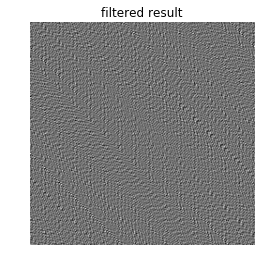

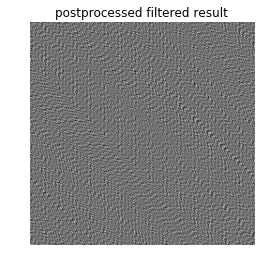

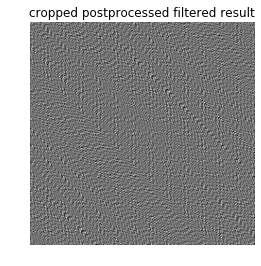

In [35]:
inverse_blur =  partial(wiener_filter, shape = noisy_fft.shape,T = 1, a = 0.1, b = 0.1, K=0.006)
apply_inverse(noisy_fft, inverse_blur);